In [1]:
import datetime
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import mplfinance as mpf
import yfinance as yf

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from numpy.lib.stride_tricks import sliding_window_view

from setup import get_task_data

SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

d:\conda\envs\imta\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
financial_data = {}
metadata = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 129
TARGET_STOCKS_COUNT = 5000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='1y')

[**                     4%%                      ]  215 of 5000 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[********              17%%                      ]  847 of 5000 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[**********            21%%                      ]  1028 of 5000 completed

Failed to get ticker 'AKO/A' reason: Expecting value: line 1 column 1 (char 0)


[**********            21%%                      ]  1068 of 5000 completed

Failed to get ticker 'TWO-C' reason: Expecting value: line 1 column 1 (char 0)


[***********           22%%                      ]  1094 of 5000 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************87%%****************      ]  4360 of 5000 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************95%%********************  ]  4733 of 5000 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  5000 of 5000 completed


319 Failed downloads:
['SRC-A', 'AHT-G', 'AHT-F', 'BEP-A', 'F-C', 'GSL-B', 'CFR-B', 'OAK-B', 'AUB-A', 'RITM-B', 'RWT-A', 'OAK-A', 'ECC-D', 'ASB-F', 'EP-C', 'GAM-B', 'AULT-D', 'GMRE-A', 'WFC-A', 'EPR-C', 'CMRE-C', 'BAC-M', 'MS-O', 'RITM-D', 'MS-A', 'CFG-E', 'PCG-D', 'ETX           ', 'EPR-G', 'CUBI-E', 'NREF-A', 'GAB-H', 'JPM-M', 'KREF-A', 'NS-B', 'GS-K', 'WFC-C', 'RPT-D', 'EFC-B', 'NEE-N', 'GLOG-A', 'COF-N', 'SCE-H', 'USB-Q', 'TWO-C', 'SPG-J', 'ETI-', 'BHR-D', 'LNC-D', 'TFC-O', 'CTA-A', 'TNP-F', 'CODI-C', 'AHT-H', 'GGN-B', 'JPM-J', 'RF-B', 'KEY-J', 'GAB-G', 'GNT-A', 'AL-A', 'PRIF-J', 'RIV-A', 'STT-G', 'GLU-A', 'NCV-A', 'MET-F', 'VNO-N', 'SEAL-B', 'WBS-G', 'PMT-A', 'WFC-L', 'ARR-C', 'MS-I', 'AHT-I', 'PCG-G', 'HT-D', 'AHT-D', 'RNR-F', 'PEB-F', 'FEI           ', 'AMH-H', 'MFA-B', 'MDV-A', 'WFC-Y', 'SPNT-B', 'HT-C', 'DX-C', 'BAC-N', 'SCHW-D', 'FHN-D', 'GNL-D', 'GS-C', 'CHMI-A', 'C-J', 'HWM-', 'USB-R', 'SF-C', 'CIM-B', 'NS-C', 'YCBD-A', 'PCG-B', 'MET-E', 'ABR-D', 'MS-P', 'FHN-E', 'AMH-G', 

In [3]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256 entries, 2022-10-25 00:00:00 to 2023-10-31 00:00:00
Columns: 30000 entries, ('Adj Close', 'A') to ('Volume', 'ZYME')
dtypes: float64(30000)
memory usage: 58.6+ MB


In [4]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [5]:
stocks_list[0]

'MCACW'

In [6]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

Our financial data is supplied with metadata: name of a stock and financial sector it belongs too

Sectors:
* Technology - category of stocks relating to the research, development, or distribution of technologically based goods and services
* Basic Materials - category made up of businesses engaged in the discovery, development, and processing of raw materials 
* Communication Services - category made up of services such as social media companies, Internet search firms, video game makers, telecom providers, and streaming media make up most of this sector
* Consumer Cyclical - category of stocks that rely heavily on the business cycle and economic conditions. Consumer cyclicals include industries such as automotive, housing, entertainment, and retail
* Consumer Defensive - category of companies that manufacture food, beverages, household and personal products, packaging, or tobacco. Also includes companies that provide services such as education and training services
* Energy - category of companies that play a role in extracting, refining, or producing sources of energy
* Financial Services - category of firms and institutions that provide financial services to commercial and retail customers
* Healthcare - category of businesses that provide medical services, manufacture medical equipment or drugs, provide medical insurance, or otherwise facilitate the provision of healthcare to patients
* Industrials - category of businesses that aid other businesses in manufacturing, shipping or producing their products
* Real Estate - category of the following: Industrial, Office, Mixed-Industrial/Office, Retail-Shopping Centers, Retail-Regional Malls, Retail-Free Standing, Residential-Apartments, Residential-Manufactured Homes, Diversified, Lodging/Resorts, Health Care, Self Storage, Specialty, Home Financing and Commercial Financing
* Utilities - category of companies that provide their customers with electricity, water, and other public utilities

In [7]:
# metadata extraction is costly and not required for classification/regression

for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    # ticker = yf.Ticker(stock)
    # sector = ticker.info.get('sector', None)

    # if not sector:
    #    print(f"No sector specified")
    #    continue

    financial_data[stock] = history
    # metadata[stock] = sector

Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 112
Too short history: 0
Too short history: 0
Too short history: 35
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 128
Too short history: 52
Too short history: 128
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 28
Too short history: 0
Too short history: 128
Too short history: 1
Too short history: 128
Too short history: 128
Too short history: 1
Too short history: 128
Too short history: 1
Too short history: 128
Too short history: 128
Too short history: 0
Too short history: 1
Too short history: 128
Too short history: 15
Too short history: 0
Too short 

In [8]:
len(financial_data)

4105

    1. Classification

Model that predicts if the next close value will be higher than current

RNN classification

In [9]:
def log_modified(n):
    if n == 0:
        return 0
    elif n < 0:
        return -np.log(-n)
    else:
        return np.log(n)

In [10]:
classification_stocks = []
classification_history = []
classification_target = []

for stock, data in financial_data.items():
    classification_stocks.append(stock)

    close_vals = data['Close'].to_numpy()
    close_vals_delta = np.diff(close_vals)
    close_vals_delta = np.insert(close_vals_delta, 0, 0)
    close_vals_delta_normalized = np.fromiter(map(lambda n: log_modified(n), close_vals_delta), dtype=np.float32)

    classification_history.append(close_vals_delta_normalized[0:HISTORY_SIZE - 1])
    classification_target.append(int(close_vals_delta_normalized[-1] > 0))

classification_data = {
    'Stock': classification_stocks,
    'History': classification_history,
    'Target': classification_target
}

In [11]:
classification_df = pd.DataFrame.from_dict(classification_data)

In [12]:
classification_df.sample(1)

,Stock,History,Target
2470,LX,"[0.0, -2.5257297, 4.605171, 1.9661121, -2.6592...",1


Values of close prices represented as a sequence and sector as one-hot vector

In [13]:
classification_train_df, classification_test_df = train_test_split(classification_df, test_size=0.2)

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [82]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True, input_shape=(None, (HISTORY_SIZE - 1))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

In [83]:
classification_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-6),
              metrics=[
                  'accuracy', 
                  tf.keras.metrics.Precision(name='precision_0', class_id=0, dtype = np.float32),
                  tf.keras.metrics.Precision(name='precision_1', class_id=1, dtype = np.float32),
                  tf.keras.metrics.Recall(name='recall_0', class_id=0, dtype = np.float32),
                  tf.keras.metrics.Recall(name='recall_1', class_id=1, dtype = np.float32),
                  tf.keras.metrics.F1Score(average='macro', dtype = np.float32),
                ])

In [84]:
train_size = len(classification_train_df)
test_size = len(classification_test_df)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([[0.], [1.]])

x_train = np.array(classification_train_df['History'].tolist()).reshape(train_size, 1, HISTORY_SIZE - 1)
y_train = enc.transform(np.array(classification_train_df['Target'].tolist(), dtype=np.float32).reshape(-1, 1)).toarray().reshape(train_size, 2)

x_test = np.array(classification_test_df['History'].tolist()).reshape(test_size, 1, HISTORY_SIZE - 1)
y_test = enc.transform(np.array(classification_test_df['Target'].tolist(), dtype=np.float32).reshape(-1, 1)).toarray().reshape(test_size, 2)

In [85]:
classification_history = classification_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=1000)

Epoch 1/1000
103/103 [==============================] - 13s 31ms/step - loss: 4.4378 - accuracy: 0.4896 - precision_0: 0.0000e+00 - precision_1: 0.0000e+00 - recall_0: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.4862 - val_loss: 3.6494 - val_accuracy: 0.4604 - val_precision_0: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.4604
Epoch 2/1000
103/103 [==============================] - 1s 14ms/step - loss: 3.6117 - accuracy: 0.5137 - precision_0: 0.0000e+00 - precision_1: 0.0000e+00 - recall_0: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.4953 - val_loss: 3.4452 - val_accuracy: 0.5323 - val_precision_0: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_0: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.4943
Epoch 3/1000
103/103 [==============================] - 1s 13ms/step - loss: 3.4499 - accuracy: 0.5204 - precision_0: 0.0000e+00 - precision_1: 0.0000e+00 - recall_0: 0.0000e+00 - recall_1: 0.0000e+00 

In [87]:
test_loss, test_acc, _, _, _, _, _ = classification_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

26/26 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.5920 - precision_0: 0.6272 - precision_1: 0.5153 - recall_0: 0.7484 - recall_1: 0.3471 - f1_score: 0.5517
Test Loss: 0.6693018078804016
Test Accuracy: 0.5919610261917114


In [88]:
def plot_classification_history(history):
    fig, ax = plt.subplots(2, 4, figsize=(15, 6))
    fig.tight_layout(pad=1.0)

    ax[0, 0].plot(history.history['accuracy'], label='accuracy')
    ax[0, 0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].set_ylim([0, 1])

    ax[0, 1].plot(history.history['loss'], label='accuracy')
    ax[0, 1].plot(history.history['val_loss'], label='val_accuracy')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].set_ylim([0, 5])

    ax[0, 2].plot(history.history['f1_score'], label='f1_score')
    ax[0, 2].plot(history.history['val_f1_score'], label='val_f1_score')
    ax[0, 2].set_xlabel('Epoch')
    ax[0, 2].set_ylabel('F1')
    ax[0, 2].set_ylim([0, 1])

    ax[1, 0].plot(history.history['precision_0'], label='precision_0')
    ax[1, 0].plot(history.history['val_precision_0'], label='val_precision_0')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Precision 0')
    ax[1, 0].set_ylim([0, 1])

    ax[1, 1].plot(history.history['precision_1'], label='precision_1')
    ax[1, 1].plot(history.history['val_precision_1'], label='val_precision_1')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Precision 1')
    ax[1, 1].set_ylim([0, 1])

    ax[1, 2].plot(history.history['recall_0'], label='recall_0')
    ax[1, 2].plot(history.history['val_recall_0'], label='val_recall_0')
    ax[1, 2].set_xlabel('Epoch')
    ax[1, 2].set_ylabel('Recall 0')
    ax[1, 2].set_ylim([0, 1])

    ax[1, 3].plot(history.history['recall_1'], label='recall_1')
    ax[1, 3].plot(history.history['val_recall_1'], label='val_recall_1')
    ax[1, 3].set_xlabel('Epoch')
    ax[1, 3].set_ylabel('Recall 1')
    ax[1, 3].set_ylim([0, 1])

    plt.show()

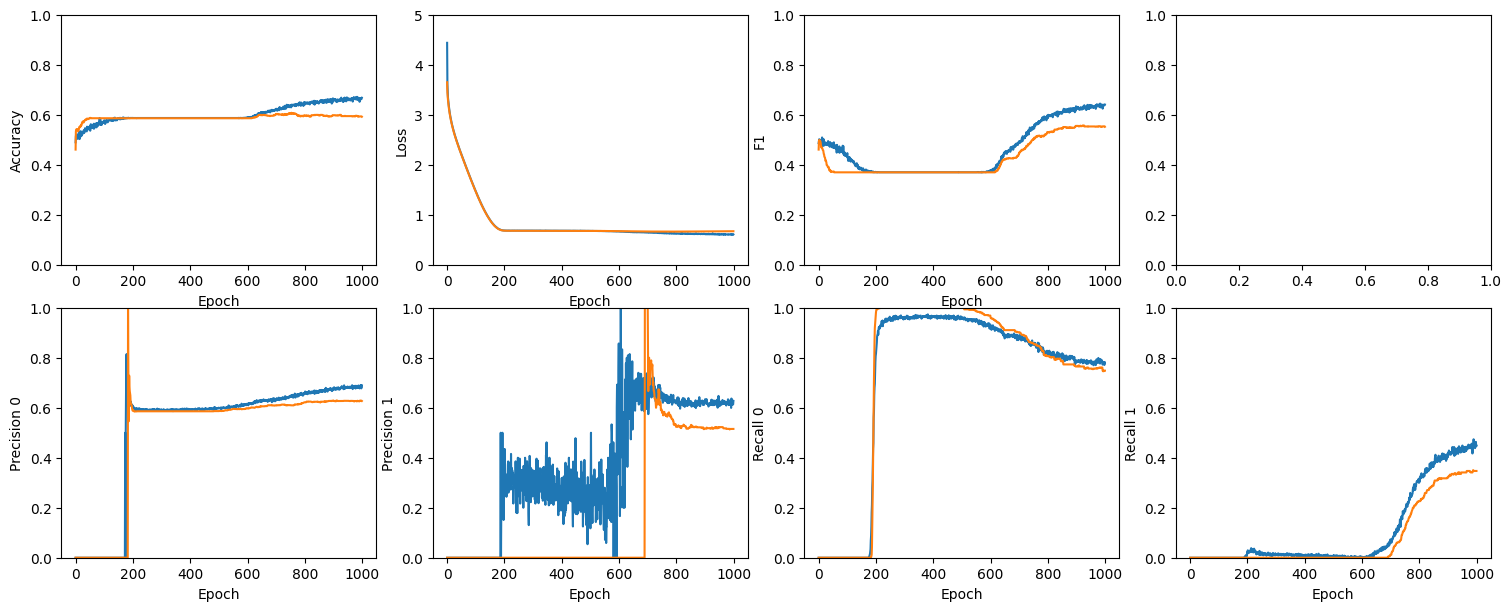

In [89]:
plot_classification_history(classification_history)

For classification we used RNN that classified whether the price of the stock will rise after the next trade. It was trained on histories of ~3.5 thousand stocks. 

We use RNN built on LSTM. RNNs are models built specifically to process sequential input and organized accordingly: neurons of such network connected as a sequence and contain internal state which is layer's memory. That way model can capture and memorize patterns if it finds them. 

Our model did not turn out great as it were unable to find any goood patterns on the data which led to selection of the most common class (despite them being pretty close and dropout usage) and further overfitting on the data.   

2. Clusterization

Model that divides data into clusters, that expected to be close to it's sectors

Probably the best approach is to pack the vector of close values into matrix and clusterize them. 

In [90]:
AGG_FUNCS = {
    col : ['mean', 'std', 'median'] for col in columns
}

def aggregate_stock(stock_df: pd.DataFrame, name: str) -> pd.DataFrame:
    
    for column in columns:
        stock_df[f'{column}_mean'] = stock_df[column].mean()
        stock_df[f'{column}_std'] = stock_df[column].std(ddof=0)
        stock_df[f'{column}_median'] = stock_df[column].median()
    stock_df = stock_df.head(1)
    stock_df.loc[:, 'Stock'] = [name]
    stock_df = stock_df.set_index('Stock').drop(columns, axis=1)
    return stock_df


def collect_financial_data(input_tickers: pd.DataFrame) -> pd.DataFrame: 
    aggregated_dfs = []
    for stock in stocks_list: 
        history = extract_history(input_tickers, stock)
        aggregated_stock = aggregate_stock(history, stock)
        aggregated_dfs.append(aggregated_stock)
    return pd.concat(aggregated_dfs, axis=0)

cluster_df = collect_financial_data(tickers_df)
cluster_df

C:\Users\strel\AppData\Local\Temp\ipykernel_2216\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
C:\Users\strel\AppData\Local\Temp\ipykernel_2216\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
C:\Users\strel\AppData\Local\Temp\ipykernel_2216\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Open_mean,Open_std,Open_median,High_mean,High_std,High_median,Low_mean,Low_std,Low_median,Close_mean,Close_std,Close_median,Adj Close_mean,Adj Close_std,Adj Close_median,Volume_mean,Volume_std,Volume_median
Stock,,,,,,,,,,,,,,,,,,
MCACW,0.000000,0.000000,0.000000,0.016000,0.000000,0.016000,0.010500,0.000000,0.010500,0.011000,0.000000,0.011000,0.011000,0.000000,0.011000,6.451000e+04,0.000000e+00,64510.0
BPT,5.878450,0.818545,5.600000,6.063821,0.870003,5.750000,5.666357,0.770261,5.370000,5.840814,0.820509,5.550000,5.840814,0.820509,5.550000,2.526663e+05,1.419522e+05,213300.0
DAC,65.061008,3.773942,66.040001,65.859302,3.684814,66.750000,64.315194,3.764879,65.510002,65.105426,3.711212,66.059998,65.105426,3.711212,66.059998,1.139092e+05,6.090903e+04,102500.0
COP,111.885426,8.865098,114.910004,113.095659,8.786760,116.339996,110.768062,8.820075,113.400002,111.906473,8.735914,114.800003,111.906473,8.735914,114.800003,5.162715e+06,2.139827e+06,4827700.0
STOK,7.809225,3.334649,6.250000,8.065543,3.488089,6.370000,7.552760,3.236451,5.910000,7.794806,3.360691,6.140000,7.794806,3.360691,6.140000,3.256304e+05,4.792442e+05,208400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASST,1.002566,0.523392,0.980000,1.072478,0.590855,1.000000,0.928190,0.471851,0.912000,0.982238,0.508495,0.955000,0.982238,0.508495,0.955000,1.045036e+06,8.001967e+06,65200.0
RGC,19.140380,4.256425,17.990000,19.588254,4.392205,18.000000,18.872310,4.285627,17.459999,19.198184,4.240541,17.660000,19.198184,4.240541,17.660000,1.493860e+03,2.303206e+03,600.0
EVV,9.172016,0.216101,9.190000,9.219544,0.216521,9.240000,9.127984,0.222715,9.150000,9.172132,0.222622,9.200000,8.954848,0.188957,8.942311,3.049238e+05,1.440622e+05,260000.0


d:\conda\envs\imta\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\strel\AppData\Local\Temp\ipykernel_2216\1014677861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster_label'] = kmeans.labels_


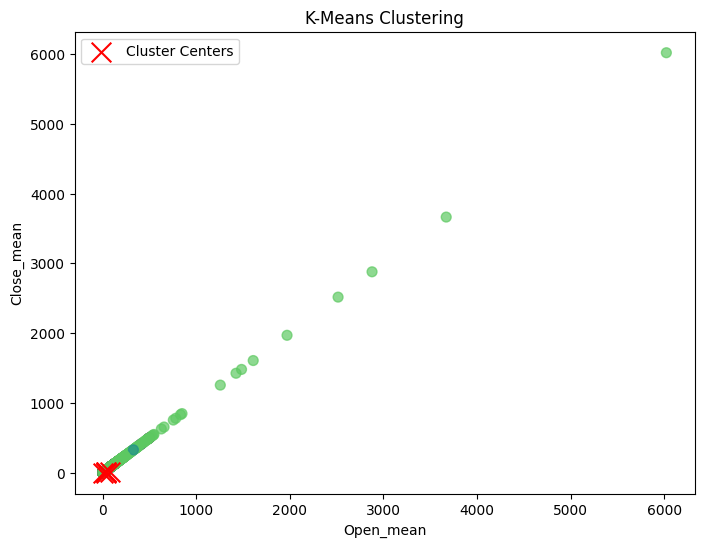

In [91]:
cluster_df = cluster_df.dropna()
kmeans = KMeans(n_clusters=5)
kmeans.fit(cluster_df)

cluster_df['cluster_label'] = kmeans.labels_

#probably compare by cartesian product
plt.figure(figsize=(8, 6))
plt.scatter(cluster_df['Open_mean'], cluster_df['Close_mean'], c=cluster_df['cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Cluster Centers')

plt.title('K-Means Clustering')
plt.xlabel('Open_mean')
plt.ylabel('Close_mean')
plt.legend()

plt.show()

3. Regression

Model that predicts next close price of a stock given the sequence of previous trades

RNN regression

In [92]:
# The Walt Disney Company stock, really, really old one
TARGET_TICKER = 'DIS'

def load_long_history():
    history = yf.download(TARGET_TICKER, period='max')
    return history
    
regression_data = load_long_history()
regression_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.092908,0.096026,0.092908,0.092908,0.058398,841958
1962-01-03,0.092908,0.094467,0.092908,0.094155,0.059182,801865
1962-01-04,0.094155,0.094467,0.093532,0.094155,0.059182,962238
1962-01-05,0.094155,0.094779,0.093844,0.094467,0.059378,962238
1962-01-08,0.094467,0.095714,0.092285,0.094155,0.059182,1282984
...,...,...,...,...,...,...
2023-10-25,82.129997,82.550003,80.519997,80.589996,80.589996,9372500
2023-10-26,80.080002,80.610001,79.419998,79.779999,79.779999,11651000
2023-10-27,79.750000,81.029999,79.230003,79.330002,79.330002,10290000


In [93]:
close_vals = regression_data['Close'].to_numpy()

mm = MinMaxScaler()
close_vals = mm.fit_transform(np.array(close_vals)[... , None]).squeeze()

close_vals

array([1.94608681e-04, 2.00786322e-04, 2.00786322e-04, ...,
       3.92736545e-01, 3.99424461e-01, 4.03932597e-01])

In [94]:
def split_input_target(sequence):
    history = sequence[:-1]
    target = sequence[-1]
    return history, target

In [95]:
regression_history = []
regression_target = []

SEQ_LENGTH = 64

for sequence in sliding_window_view(close_vals, SEQ_LENGTH + 1):
    history, target = split_input_target(sequence)

    regression_history.append(history)
    regression_target.append(target)

regression_dict = {
    'History': regression_history,
    'Target': regression_target
}

In [96]:
regression_df = pd.DataFrame.from_dict(regression_dict)

In [97]:
regression_df.sample(1)

,History,Target
11792,"[0.12863787426947706, 0.11977017869611689, 0.1...",0.09609


In [98]:
regression_train_df, regression_test_df = train_test_split(regression_df, test_size=0.2)

In [99]:
regression_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,  return_sequences=True, input_shape=(None, SEQ_LENGTH)),
    tf.keras.layers.Dense(1)
])

In [100]:
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(2e-5),
            )

In [101]:
train_size = len(regression_train_df)
test_size = len(regression_test_df)

x_train = np.array(regression_train_df['History'].tolist()).reshape(train_size, 1, SEQ_LENGTH)
y_train = np.array(regression_train_df['Target'].tolist()).reshape(train_size, 1, 1)

x_test = np.array(regression_test_df['History'].tolist()).reshape(test_size, 1, SEQ_LENGTH)
y_test = np.array(regression_test_df['Target'].tolist()).reshape(test_size, 1, 1)

In [102]:
regression_history = regression_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
388/388 [==============================] - 3s 4ms/step - loss: 0.0141 - val_loss: 6.3358e-04
Epoch 2/100
388/388 [==============================] - 1s 3ms/step - loss: 5.1756e-04 - val_loss: 5.3372e-04
Epoch 3/100
388/388 [==============================] - 1s 3ms/step - loss: 4.7105e-04 - val_loss: 4.9445e-04
Epoch 4/100
388/388 [==============================] - 1s 3ms/step - loss: 4.3759e-04 - val_loss: 4.6247e-04
Epoch 5/100
388/388 [==============================] - 1s 3ms/step - loss: 4.0755e-04 - val_loss: 4.3325e-04
Epoch 6/100
388/388 [==============================] - 1s 3ms/step - loss: 3.8083e-04 - val_loss: 4.0325e-04
Epoch 7/100
388/388 [==============================] - 1s 3ms/step - loss: 3.5275e-04 - val_loss: 3.8033e-04
Epoch 8/100
388/388 [==============================] - 1s 3ms/step - loss: 3.2535e-04 - val_loss: 3.5416e-04
Epoch 9/100
388/388 [==============================] - 1s 3ms/step - loss: 2.9954e-04 - val_loss: 3.1975e-04
Epoch 10/100
388/388 [=

In [103]:
test_loss = regression_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)

 1/97 [..............................] - ETA: 2s - loss: 1.4504e-05

97/97 [==============================] - 0s 2ms/step - loss: 3.6957e-05
Test Loss: 3.695708801387809e-05


In [104]:
def plot_regression_history(history):
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=5.0)

    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_ylim([0, 0.001])

    plt.show()

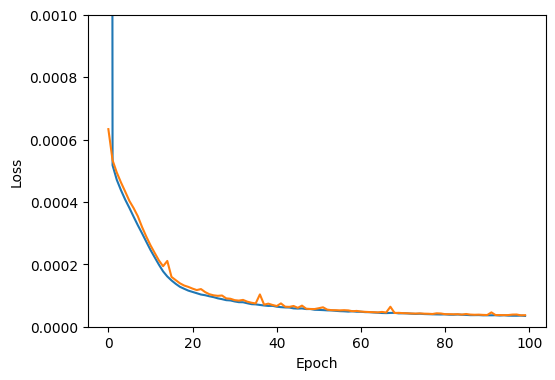

In [105]:
plot_regression_history(regression_history)

In [106]:
def inverse_transform_scalar(n):
    return mm.inverse_transform(n.reshape(1, -1))[0]

def compare_predictions_to_target(predictions, actual_values):
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=5.0)

    ax.plot(predictions, label='predicted')
    ax.plot(actual_values, label='actual')
    ax.set_xlabel('Time')
    ax.set_ylabel('Close')
    ax.set_ylim([
            inverse_transform_scalar(np.min(segment)), 
            inverse_transform_scalar(np.max(segment)) * 1.1
        ])

    plt.legend(loc="upper right")
    plt.show()

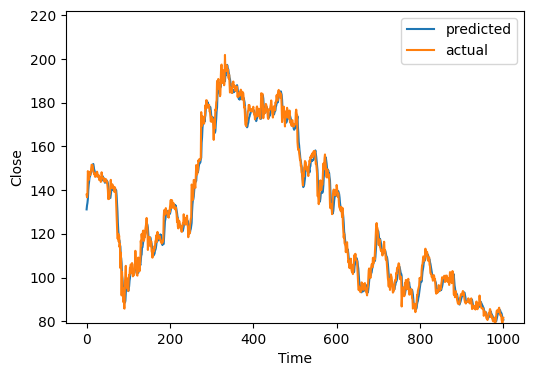

In [107]:
predictions = []
actual_values = []

segment = close_vals[-(1000 + SEQ_LENGTH + 1):]

for sequence in sliding_window_view(segment, SEQ_LENGTH + 1):
    history, target = split_input_target(sequence)

    prediction = regression_model.predict(history.reshape(1, 1, SEQ_LENGTH), verbose=0)
    predictions.append(inverse_transform_scalar(prediction.flatten()[0]))
    actual_values.append(inverse_transform_scalar(target))

compare_predictions_to_target(predictions, actual_values)

In [111]:
predictions = []
actual_values = []

segment = close_vals[-(100 + SEQ_LENGTH + 1):]

for sequence in sliding_window_view(segment, SEQ_LENGTH + 1):
    history, target = split_input_target(sequence)

    history = np.concatenate([history, np.array(actual_values)])[-SEQ_LENGTH:]
 
    prediction = regression_model.predict(history.reshape(1, 1, SEQ_LENGTH), verbose=0)
    predictions.append(inverse_transform_scalar(prediction.flatten()[0]))
    actual_values.append(inverse_transform_scalar(target))

compare_predictions_to_target(predictions, actual_values[1:])

[0.49166828 0.47601356 0.46328174 0.45847634 0.4622414  0.46095335
 0.46684864 0.46144874 0.46650186 0.47799518 0.46987059 0.47447783
 0.4658083  0.47343749 0.46947426 0.47963001 0.48572343 0.49578008
 0.49394712 0.49300585 0.49469023 0.49498746 0.49914882 0.49721675
 0.48493081 0.49929743 0.49464068 0.4966223  0.49974331 0.48894355
 0.48557482 0.49300585 0.49355079 0.48527759 0.47834196 0.4947893
 0.50752112 0.50608445 0.49810848 0.49939653 0.48250332 0.49771215
 0.50984951 0.50593583 0.50078365 0.45703967 0.45545439 0.45976439
 0.45045086 0.45931851 0.46422302 0.45228382 0.45461221 0.44470418
 0.44098866 0.43638143 0.43712454 0.43479614 0.4354897  0.43861072
 0.44941048 0.45054992 0.4562966  0.45808001]
[0.47601356 0.46328174 0.45847634 0.4622414  0.46095335 0.46684864
 0.46144874 0.46650186 0.47799518 0.46987059 0.47447783 0.4658083
 0.47343749 0.46947426 0.47963001 0.48572343 0.49578008 0.49394712
 0.49300585 0.49469023 0.49498746 0.49914882 0.49721675 0.48493081
 0.49929743 0.4946

KeyboardInterrupt: 

For regression we used multilayer RNN as we were again dealing with time sequences. However, this time model was trained on multiple chunks of price history of one stock rather than multiple stocks.

Regression with RNNs demonstrates good results in price prediction, but it's still not good as an advisor for various reasons:
1) Same as the similar RNN we used for classification it's bad at guessing when the stock will changes its direction so that prediction appears somewhat shifted, but model compensates it by following current trends with good precision
2) It can't make long-term predictions which is visible from the graphics.
3) It predicts on scaled data and error on unscaled data is bigger, however not that much. Our model also does not care about inflation. 